In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

julialisehansen_test_images_1_300_path = kagglehub.dataset_download('julialisehansen/test-images-1-300')
julialisehansen_test_images_301_600_path = kagglehub.dataset_download('julialisehansen/test-images-301-600')
julialisehansen_test_images_601_1000_path = kagglehub.dataset_download('julialisehansen/test-images-601-1000')
julialisehansen_test_data_1001_1500_path = kagglehub.dataset_download('julialisehansen/test-data-1001-1500')
julialisehansen_test_data_1501_rest_path = kagglehub.dataset_download('julialisehansen/test-data-1501-rest')
julialisehansen_best_model_path = kagglehub.dataset_download('julialisehansen/best-model')
julialisehansen_test_images_2030_2500_path = kagglehub.dataset_download('julialisehansen/test-images-2030-2500')
julialisehansen_test_images_2501_3009_path = kagglehub.dataset_download('julialisehansen/test-images-2501-3009')
julialisehansen_j_edi_plastic_prediction_path = kagglehub.notebook_output_download('julialisehansen/j-edi-plastic-prediction')

print('Data source import complete.')


## Check GPU Memory Usage  and Availability

In [ ]:
!nvidia-smi

Wed Apr  9 22:49:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Process:

1. Import the data from Roboflow
2. Train the model with exisiting train data to get a baseline training model
3. Move a portion of the pseudo labeled test data from the test folder into the training folder
4. Retrain the model with this new batch of training data and compare results
5. Repeat steps 1-4 for each iteration of adding pseudo data, making sure to run the file cleanup cells as needed

## Import Libraries

In [ ]:
pip install TensorFlow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install "ultralytics<=8.3.40" supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.40 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6282.1/8062.4 GB disk)


In [ ]:
# Import necessary libraries/packages
import os
import shutil
from IPython import display
display.clear_output()
#import ultralytics
#ultralytics.checks()
#from ultralytics import YOLO
from IPython.display import display, Image

In [ ]:
# Set home directory
HOME = os.getcwd()
print(HOME)

/kaggle/working


## Clean up files: Run the second cell when working on a new batch of psudeo labeled data

In [ ]:
#RUN THIS ONLY AFTER SAVING PREDS TO TRAIN TO DELETE FOLDER
shutil.rmtree('/kaggle/working/datasets/Underwater-Trash-Detection-2-1/train/predict')
shutil.rmtree('/kaggle/working/runs/detect/predict')
shutil.rmtree('/kaggle/working/runs/detect/train')
shutil.rmtree('/kaggle/working/runs/detect/predict')
shutil.rmtree('/kaggle/working/runs/detect/val')
os.remove('/kaggle/working/yolov8s.pt')

In [ ]:
# RUN THIS CELL AFTER EACH PSUDEO LABELING ITERATION
shutil.rmtree('/kaggle/working/datasets/Underwater-Trash-Detection-1')
#shutil.rmtree('/kaggle/working/runs/detect/val2')

## Import Roboflow Data

In [ ]:
# Install RoboFlow library and download dataset
# DO NOT RUN IF FINE TUNING WITH PSEUDO DATA
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="HhNnM9lzMEeBCZh4mD5x")
project = rf.workspace("plastic-detection-r16is").project("underwater_plastics_og_data")
version = project.version(1)
dataset = version.download("yolov11")



/kaggle/working/datasets
loading Roboflow workspace...
loading Roboflow project...


## Train Model

In [ ]:
# Ensure train size has increased after adding pseudo labeled images
def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])

directory_path = f'/kaggle/working/datasets/Underwater_plastics-1/train/images'
print(count_files(directory_path))

5020


In [ ]:
%cd {HOME}
# Use the train mode to finetune the YOLO v8 model over 25 epochs

!yolo task=detect mode=train model=yolov11s.pt data='/kaggle/working/datasets/underwater_plastics_og_data-1/data.yaml' epochs=25 imgsz=640 plots=True

/kaggle/working
Traceback (most recent call last):
  File "/opt/conda/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/cfg/__init__.py", line 943, in entrypoint
    model = YOLO(model, task=task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/models/yolo/model.py", line 23, in __init__
    super().__init__(model=model, task=task, verbose=verbose)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 145, in __init__
    self._load(model, task=task)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/model.py", line 288, in _load
    self.model, self.ckpt = attempt_load_one_weight(weights)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 910, in attempt_load_one_weight
    ckpt, weight = torch_safe_load(weight)  # load ckpt
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/nn/tasks.py", line 837, in torch_safe_load
    ckpt

## Results from Training

/kaggle/working


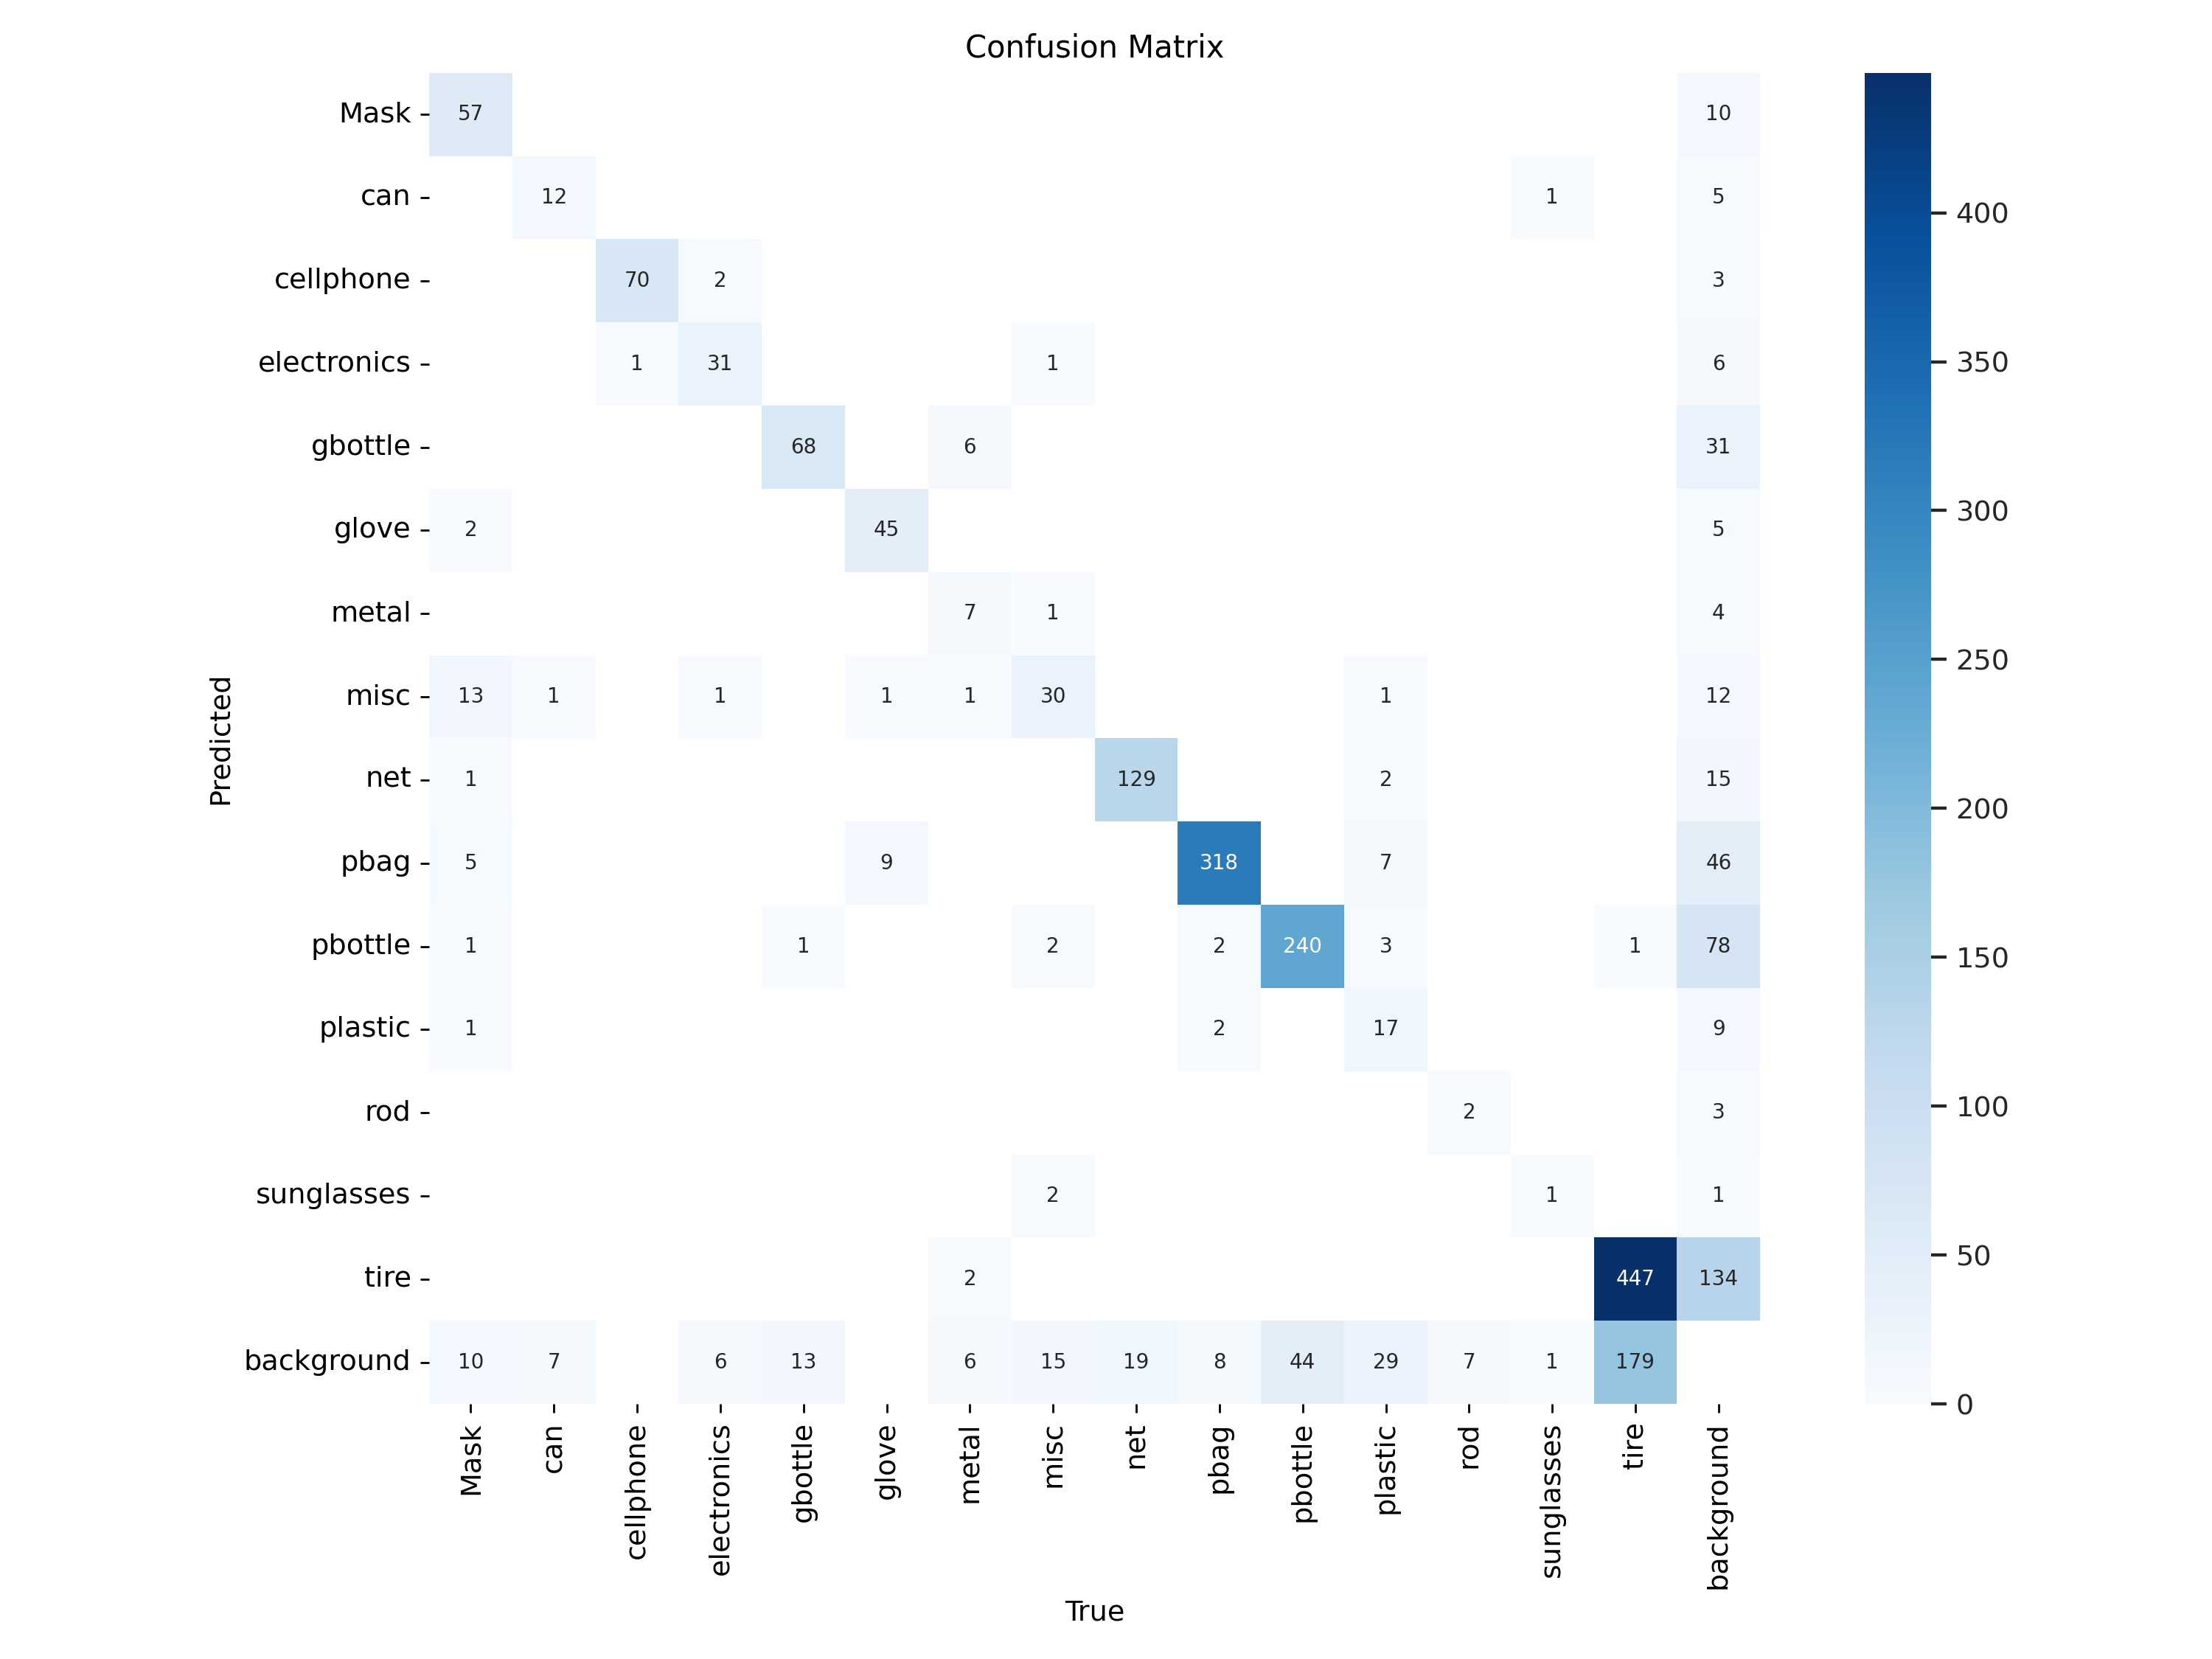

In [ ]:
%cd {HOME}
# Display the confusion matrix
Image(filename= '/kaggle/working/runs/detect/train2/confusion_matrix.png', width=600)

/kaggle/working


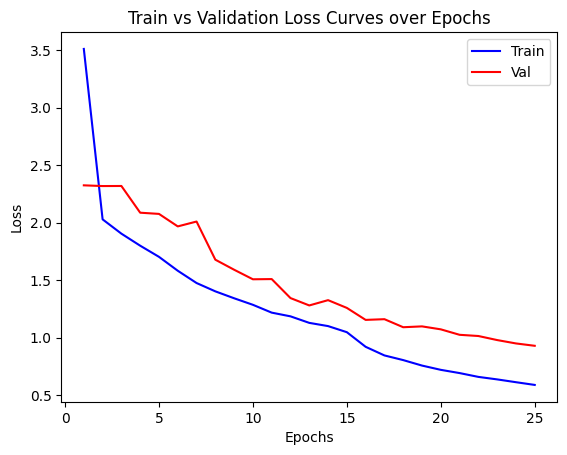

In [ ]:
# Display the Train Validation Loss Curves
import pandas as pd
import matplotlib.pyplot as plt
%cd {HOME}

df = pd.read_csv(f'{HOME}/runs/detect/train2/results.csv')
plt.plot(df.iloc[:,0], df.iloc[:,2], label='Train', color='blue')

# Plot the second curve
plt.plot(df.iloc[:,0], df.iloc[:,9], label='Val', color='red')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss Curves over Epochs')
plt.legend()

# Show the graph
plt.show()

/kaggle/working


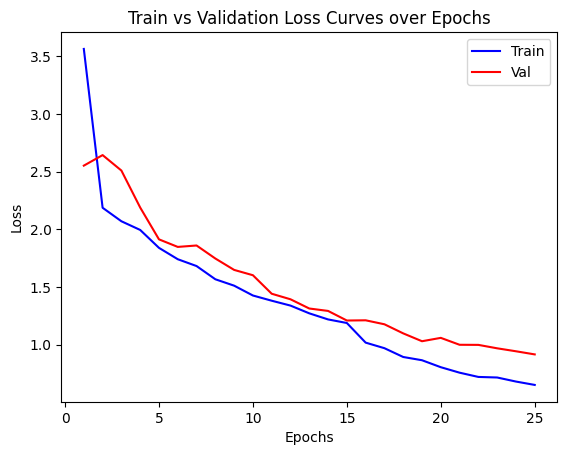

In [ ]:
# Display the Train Validation Loss Curves
import pandas as pd
import matplotlib.pyplot as plt
%cd {HOME}

df = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
plt.plot(df.iloc[:,0], df.iloc[:,2], label='Train', color='blue')

# Plot the second curve
plt.plot(df.iloc[:,0], df.iloc[:,9], label='Val', color='red')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss Curves over Epochs')
plt.legend()

# Show the graph
plt.show()

/kaggle/working


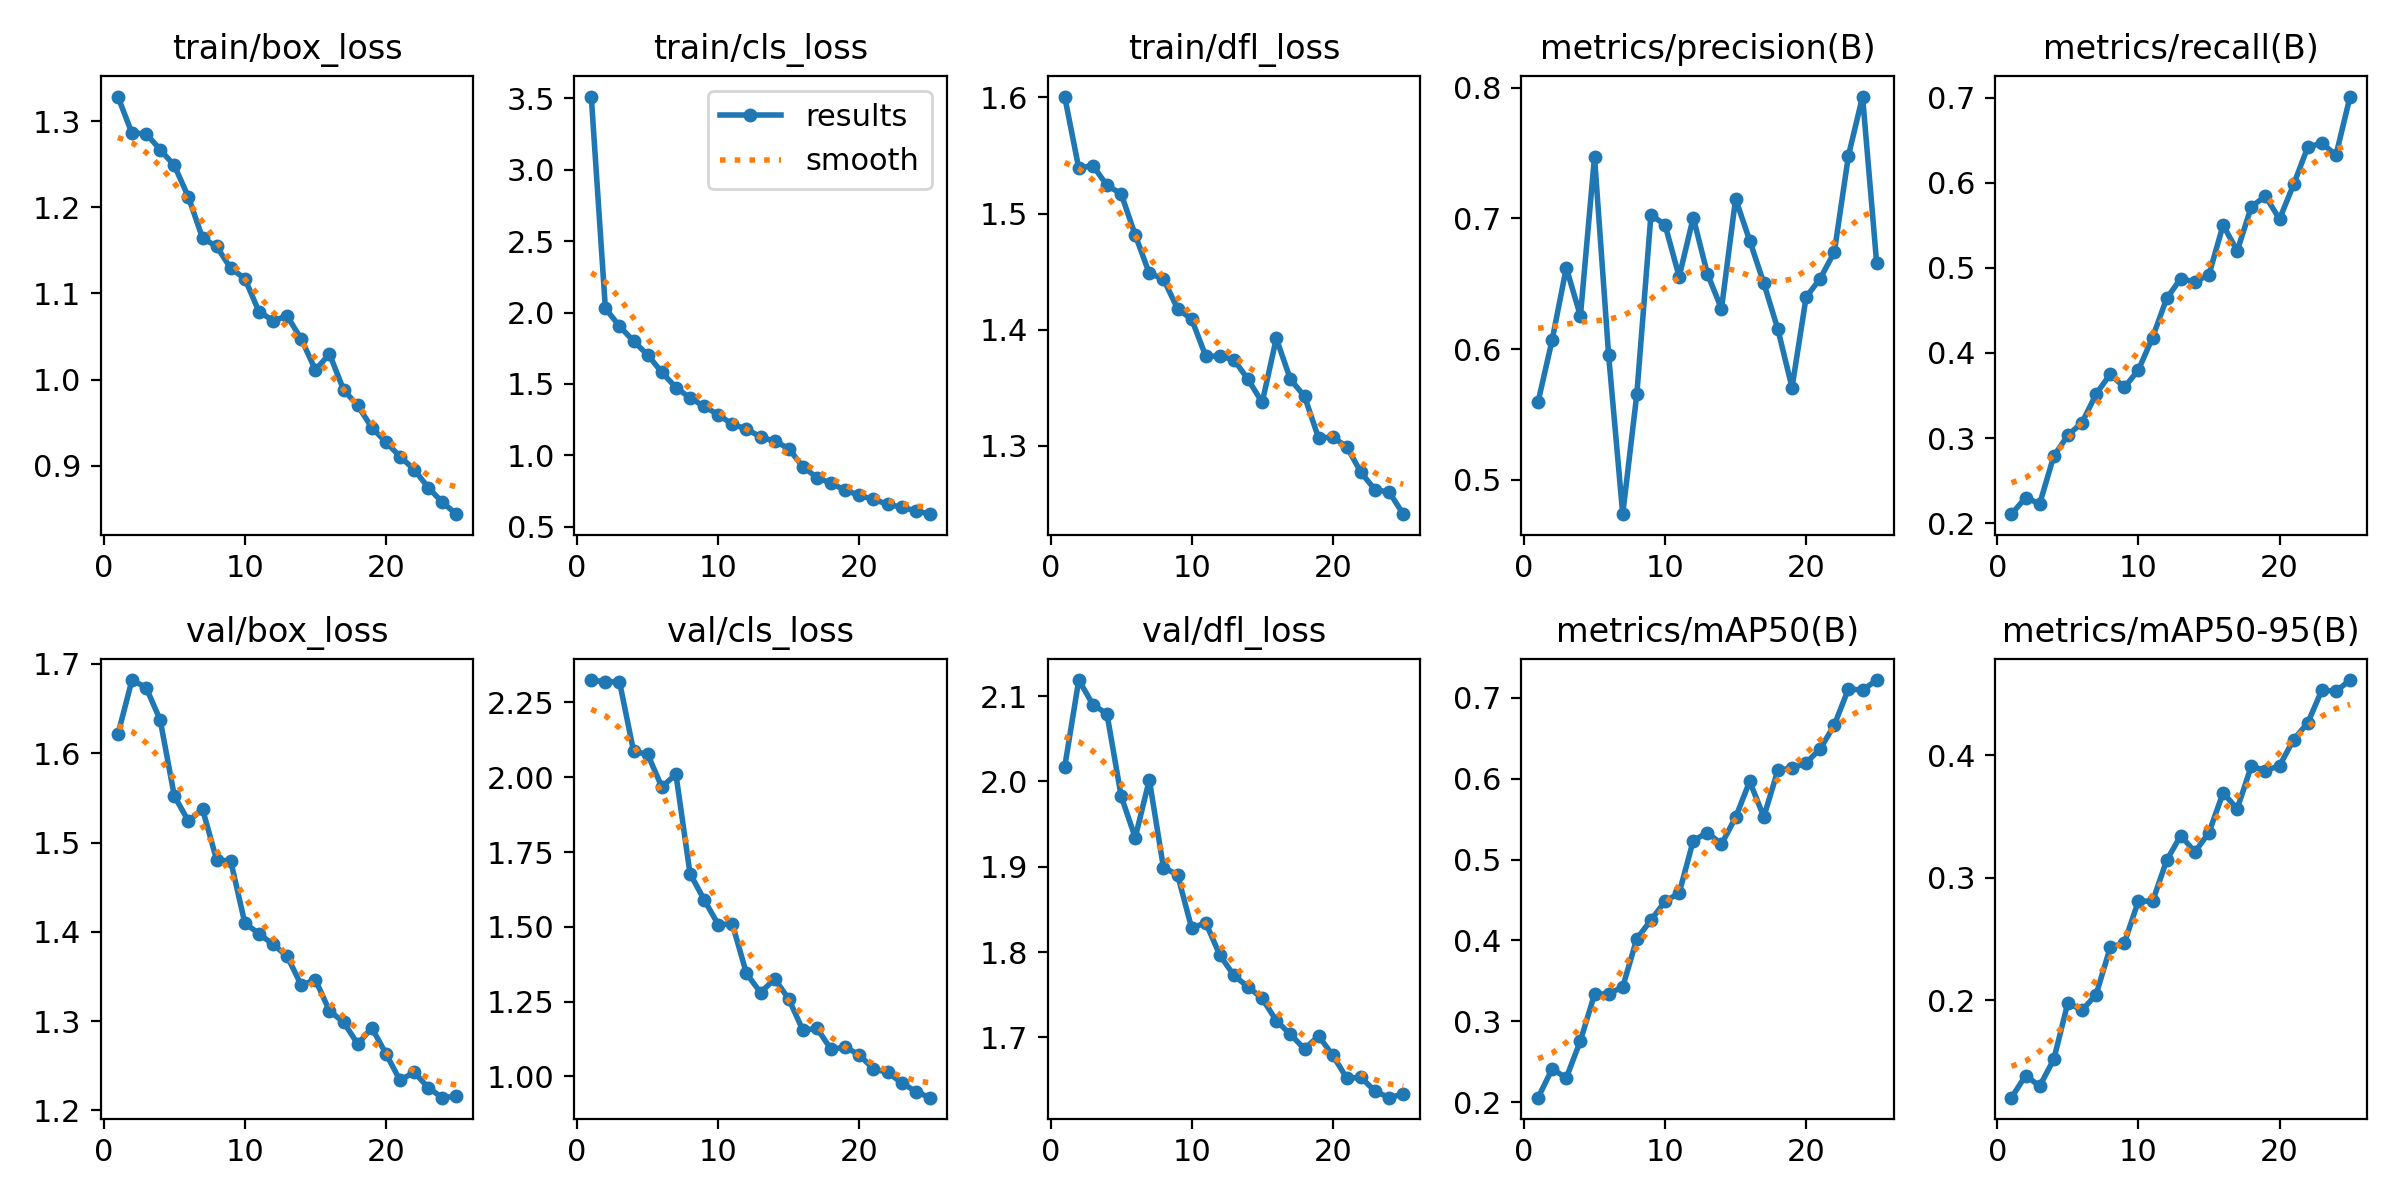

In [ ]:
%cd {HOME}
# Display results which includes loss, accuracy, precision, and recall
Image(filename=f'{HOME}/runs/detect/train2/results.png', width=600)

/kaggle/working


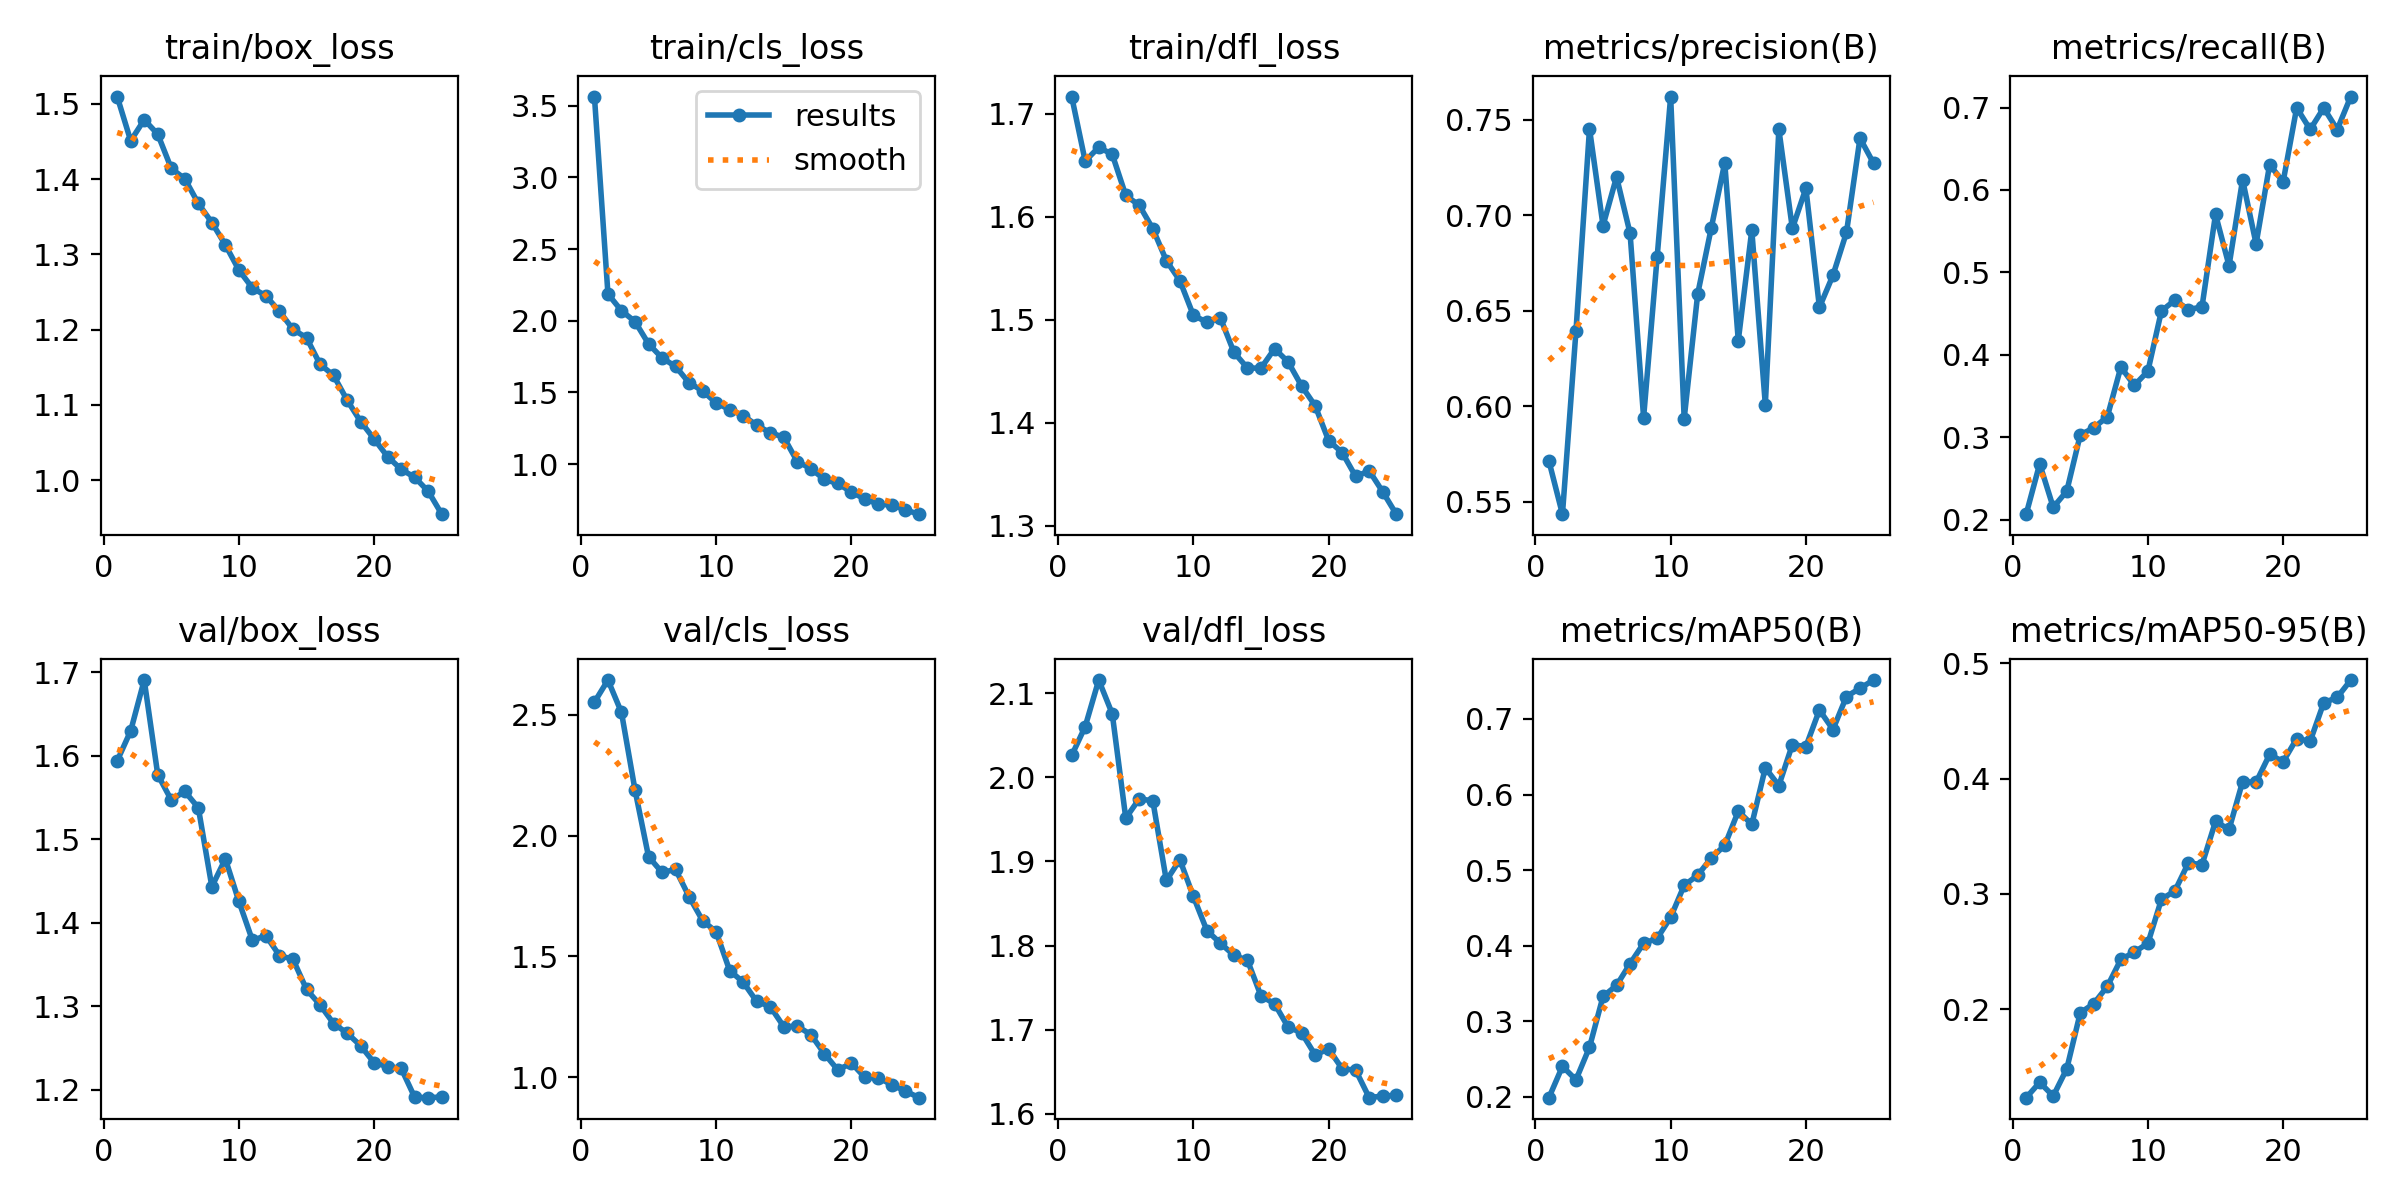

In [ ]:
%cd {HOME}
# Display results which includes loss, accuracy, precision, and recall
Image(filename='/kaggle/working/runs/detect/train/results.png', width=600)

/kaggle/working


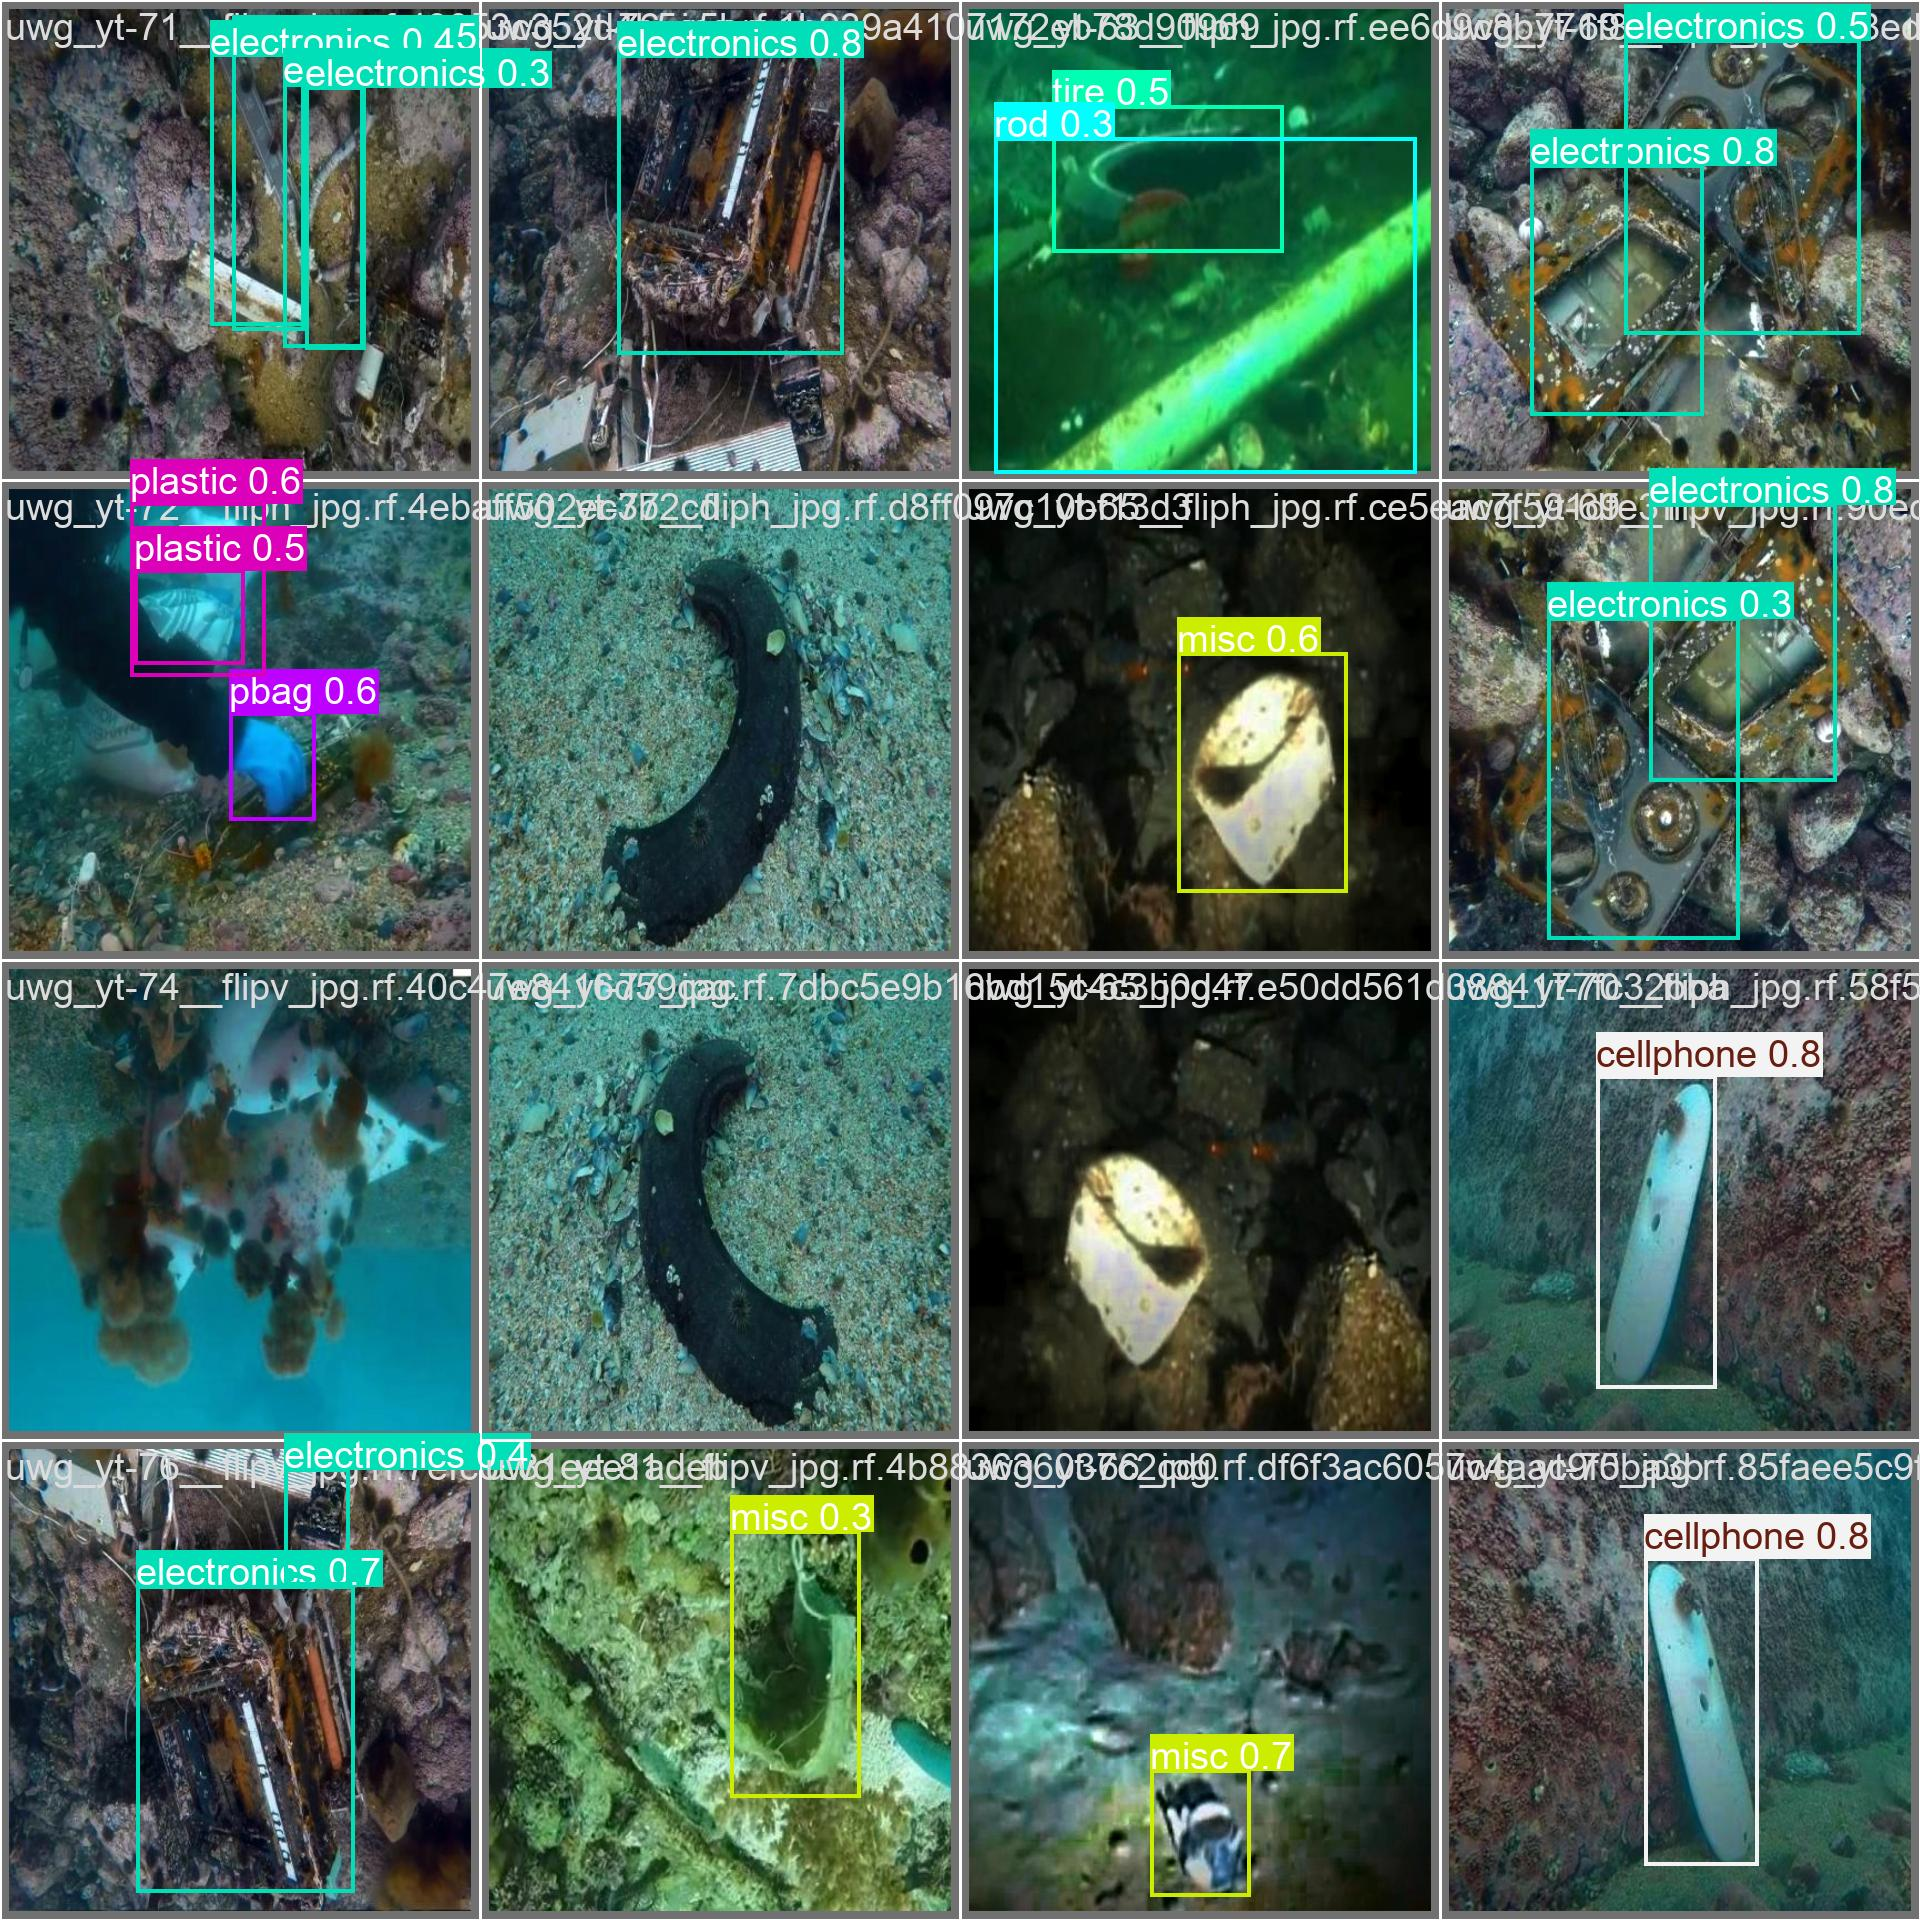

In [ ]:
%cd {HOME}
# Display validation predictions
Image(filename='/kaggle/working/runs/detect/train2/val_batch0_pred.jpg', width=600)

## Validate the model

In [ ]:
%cd {HOME}
# Set mode to validate
!yolo task=detect mode=val model=/kaggle/working/runs/detect/train2/weights/best.pt data='/kaggle/input/underwater-plastics-8/underwater_plastics - Copy/data.yaml'

/kaggle/working
Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,131,389 parameters, 0 gradients, 28.5 GFLOPs
val: Scanning /kaggle/input/underwater-plastics-8/underwater_plastics - Copy/val
val: WARNING ⚠️ Cache directory /kaggle/input/underwater-plastics-8/underwater_plastics - Copy/valid is not writeable, cache not saved.
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all       1001       1891      0.665      0.699      0.723      0.461
                  Mask         77         90      0.928      0.721      0.852      0.573
                   can         18         20      0.602      0.604      0.655      0.259
             cellphone         61         71      0.913      0.986      0.984      0.865
           electronics         27         40      0.719      0.775      0.768      0.423
               gbottle         36         82      0.601      0.841      0.81

## Test the model with new data and add Psudeo Labeled Data to Train Folder

In [ ]:
#%cd {HOME}
# Set mode to predict
!yolo task=detect mode=predict model= /kaggle/working/runs/detect/train2/weights/best.pt source='/kaggle/input/test-images-2501-3009/Test Images (2501-3009)' save=True save_txt=True

Ultralytics YOLOv8.2.103 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 11,131,389 parameters, 0 gradients, 28.5 GFLOPs

image 1/509 /kaggle/input/test-images-2501-3009/Test Images (2501-3009)/test (2501).jpg: 608x800 2 gbottles, 46.0ms
image 2/509 /kaggle/input/test-images-2501-3009/Test Images (2501-3009)/test (2502).jpg: 608x800 2 gbottles, 18.4ms
image 3/509 /kaggle/input/test-images-2501-3009/Test Images (2501-3009)/test (2503).jpg: 608x800 1 gbottle, 18.4ms
image 4/509 /kaggle/input/test-images-2501-3009/Test Images (2501-3009)/test (2504).jpg: 608x800 1 gbottle, 18.4ms
image 5/509 /kaggle/input/test-images-2501-3009/Test Images (2501-3009)/test (2505).jpg: 608x800 1 gbottle, 18.4ms
image 6/509 /kaggle/input/test-images-2501-3009/Test Images (2501-3009)/test (2506).jpg: 608x800 (no detections), 18.4ms
image 7/509 /kaggle/input/test-images-2501-3009/Test Images (2501-3009)/test (2507).jpg: 608x800 1 gbottle, 18.3ms
image 8/509 /kaggle/i

In [ ]:
new_pred_path=os.path.join('/kaggle/working/runs/detect/predict', 'pred-Images')
os.makedirs(new_pred_path)

In [ ]:
import random

# Run this cell to move prediction images into train images, prediction labels into
# train labels, and finally delete those images and labels from the test batch so
# that the images are not used for fine tuning and predictions
# Code modified from CHAT GPT when asking for help with moving files to
# target folders

# Define paths
predictions_folder = '/kaggle/working/runs/detect/predict'
predictions_folder_labels = '/kaggle/working/runs/detect/predict/labels'
os.makedirs(os.path.dirname('/kaggle/working/runs/detect/predict/pred-Images'), exist_ok=True)
train_images_folder = '/kaggle/working/runs/detect/predict/pred-Images'
#train_labels_folder = '/kaggle/working/datasets/Underwater-Trash-Detection-1/train/labels'

labels = os.listdir(predictions_folder_labels)
random.shuffle(labels)
count = 0

# When changing data percentage try randomizing file order using random.shuffle(file_list)
# List all labels in the predictions folder

for label_file in labels:
        if label_file.endswith('.txt'):  # Assuming YOLO labels are in text files
            image_file = label_file.replace('.txt', '.jpg') # Get equivalent image corresponding to the label
            source_path_label = os.path.join(predictions_folder_labels, label_file)
            source_path_image = os.path.join(predictions_folder, image_file)
            count+=1
            # Move labels to the train labels folder and images to the train images folder
            #dest_path_label_t = os.path.join(train_labels_folder, label_file)
            dest_path_image_t = os.path.join(train_images_folder, image_file)
            #shutil.move(source_path_label, dest_path_label_t)
            shutil.move(source_path_image, dest_path_image_t)
            print(f"Moved label: {label_file}")
            #os.remove(f'/kaggle/working/datasets/Underwater-Trash-Detection-2-1/test/labels/{label_file}')
            print(f"Moved image: {image_file}")
            #os.remove(f'/kaggle/working/datasets/Underwater-Trash-Detection-2-1/test/images/{image_file}')


Moved label: test (2934).txt
Moved image: test (2934).jpg
Moved label: test (2722).txt
Moved image: test (2722).jpg
Moved label: test (2590).txt
Moved image: test (2590).jpg
Moved label: test (2771).txt
Moved image: test (2771).jpg
Moved label: test (2635).txt
Moved image: test (2635).jpg
Moved label: test (2981).txt
Moved image: test (2981).jpg
Moved label: test (2715).txt
Moved image: test (2715).jpg
Moved label: test (3002).txt
Moved image: test (3002).jpg
Moved label: test (2643).txt
Moved image: test (2643).jpg
Moved label: test (2504).txt
Moved image: test (2504).jpg
Moved label: test (2724).txt
Moved image: test (2724).jpg
Moved label: test (2707).txt
Moved image: test (2707).jpg
Moved label: test (2785).txt
Moved image: test (2785).jpg
Moved label: test (2668).txt
Moved image: test (2668).jpg
Moved label: test (2953).txt
Moved image: test (2953).jpg
Moved label: test (2976).txt
Moved image: test (2976).jpg
Moved label: test (2878).txt
Moved image: test (2878).jpg
Moved label: t

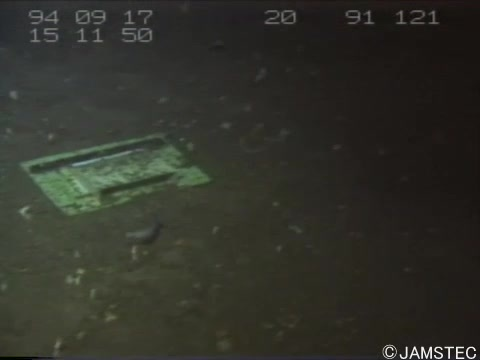

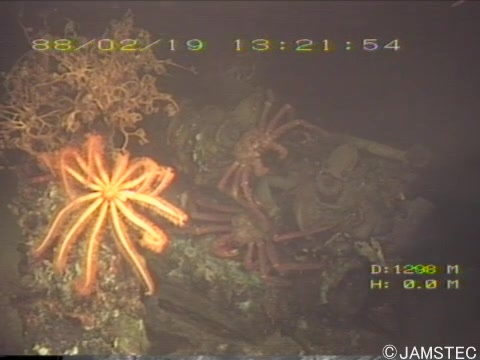

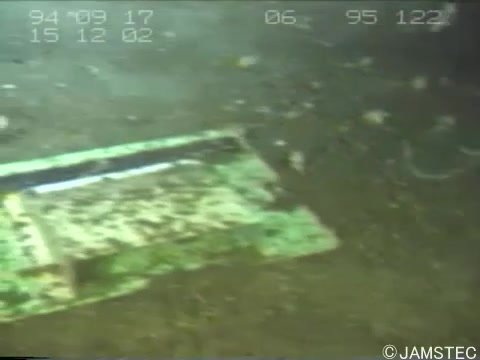

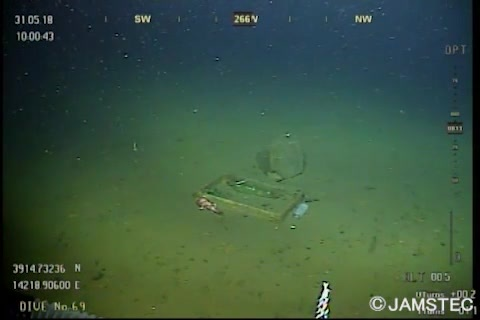

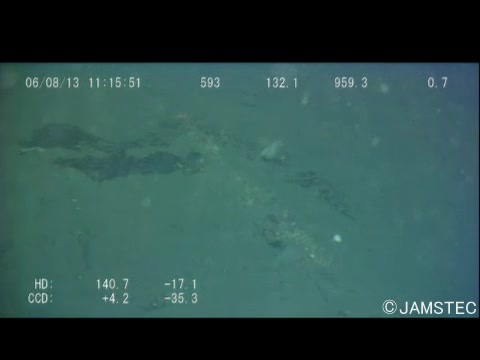

In [ ]:
# Display prediction images with labels

import glob
from IPython.display import Image, display

# Define the base path where the folders are located
base_path = '/kaggle/working/datasets/Underwater-Trash-Detection-2-1/train/'

# List all directories that start with 'predict' in the base path
subfolders = [os.path.join(base_path, d) for d in os.listdir(base_path)
              if os.path.isdir(os.path.join(base_path, d)) and d.startswith('predict')]

# Find the latest folder by modification time
latest_folder = max(subfolders, key=os.path.getmtime)

image_paths = glob.glob(f'{latest_folder}/*.jpg')[:5]

# Display each image
for image_path in image_paths:
    display(Image(filename=image_path, width=600))
    print("\n")